## 1D Model

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.analytic import UpperConfidenceBound, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.cross_validation import gen_loo_cv_folds
from botorch.posteriors.gpytorch import GPyTorchPosterior
import math
import GPy

## Identify and plot the objective function

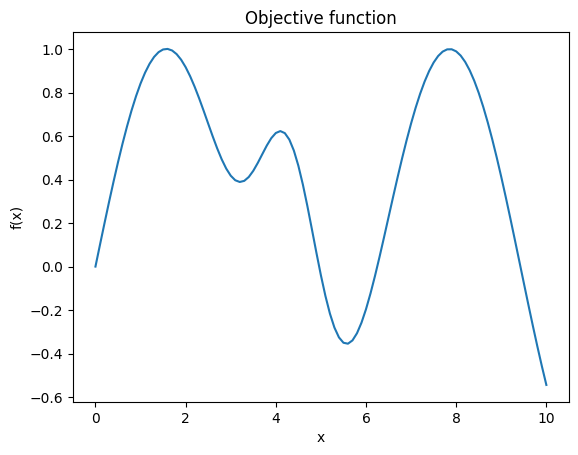

In [213]:
def F(X):
    y = []
    for x in X:
        y.append(np.sin(x) + 1.5 * np.exp(-(x - 4.3) ** 2))
    return torch.tensor(y)

x = np.linspace(0,10,101)
y = F(x)
plt.plot(x,y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Objective function")
plt.show()

## Retrive initial dataset

(tensor([[3.8859e+00],
         [6.7543e+00],
         [6.2969e+00],
         [8.1359e+00],
         [3.9630e-01],
         [1.2334e+00],
         [3.9836e+00],
         [4.7798e+00],
         [4.1437e-03],
         [6.0021e+00]]),
 tensor([[ 0.5862],
         [ 0.4575],
         [ 0.0415],
         [ 0.9605],
         [ 0.3860],
         [ 0.9437],
         [ 0.6111],
         [ 0.1938],
         [ 0.0041],
         [-0.1946]]),
 0.9605215787887573)

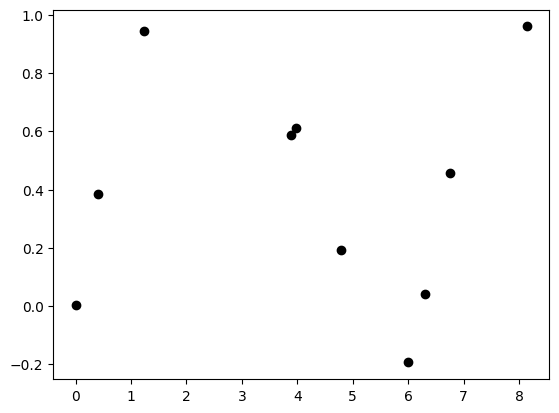

In [214]:
n = 10 # Number of training points
train_x = torch.rand(n,1)*10
train_y = F(train_x).unsqueeze(-1)
best_observed = train_y.max().item()
plt.plot(train_x,train_y,'o', color = 'black')
plt.show
train_x,train_y,best_observed

## Fit GP model

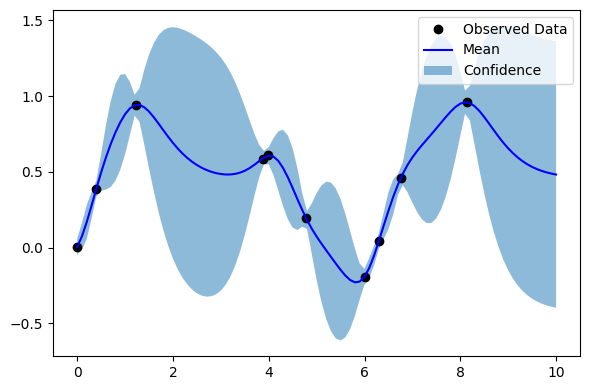

In [215]:
model = SingleTaskGP(train_x,train_y)
mll = ExactMarginalLogLikelihood(model.likelihood,model)
fit_gpytorch_model(mll)

# Plot results
model.eval()

# Initialize plot
f,ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'ko')
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()

## Acquistion function

In [216]:
EI = qExpectedImprovement(
    model = model,
    best_f = best_observed
)

## Optimise acquisition function

In [217]:
candidates_x,_ = optimize_acqf(
    acq_function = EI,
    bounds = torch.tensor([[0.],[10.]]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x
candidates_y = F(candidates_x).unsqueeze(-1)

candidates_x,candidates_y

(tensor([[ 2.6734],
         [ 7.4612],
         [ 1.6220],
         [10.0000],
         [ 2.0496],
         [ 7.6872],
         [ 7.8917],
         [ 0.9925],
         [ 8.5510],
         [ 9.0241]]),
 tensor([[ 0.5577],
         [ 0.9239],
         [ 0.9998],
         [-0.5440],
         [ 0.8970],
         [ 0.9861],
         [ 0.9993],
         [ 0.8374],
         [ 0.7668],
         [ 0.3900]]))

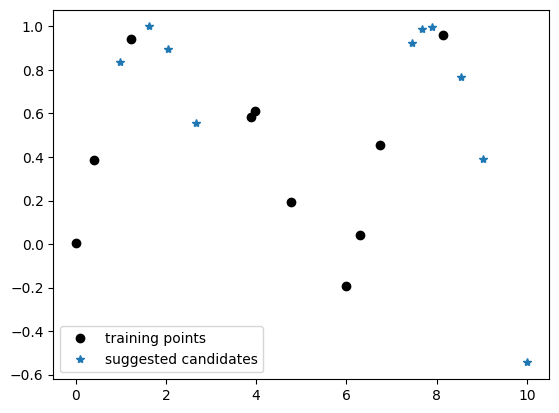

In [218]:
plt.plot(train_x,train_y,'o', color = 'black')
plt.plot(candidates_x,candidates_y,'*')
plt.legend(['training points','suggested candidates'])
plt.show()

## Take in suggested data

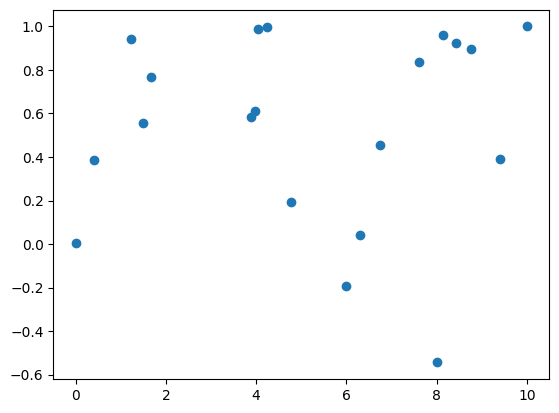

In [219]:
combine_x = (train_x,candidates)
combine_y = (train_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y
plt.plot(posterior_x,posterior_y,'o')

## Result Visualisation

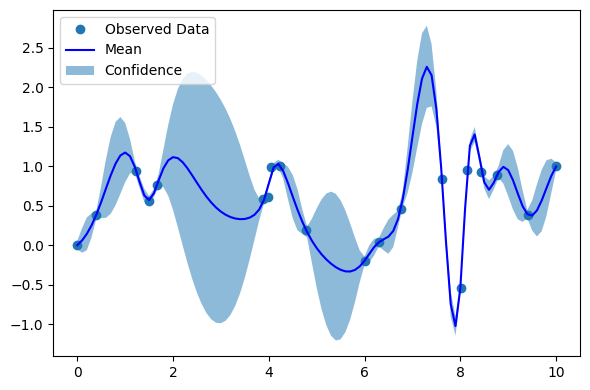

In [220]:
posterior_model = SingleTaskGP(posterior_x,posterior_y)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

# Plot
posterior_model.eval()
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = posterior_model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o')
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()